# 5. Coupon Use Prediction Model

## 5.1 Contents <a id='5.1'></a>

* [5.1 Contents](#5.1)
* [5.2 Introduction](#5.2)
* [5.3 Imports](#5.3)
* [5.4 Load Data](#5.4)
* [5.5 Feature Engineering ](#5.5)
* [5.6 Modeling](#5.6)
    * [5.6.1 Train Test Splits](#5.6.1)
        * [5.6.1a No Resampling ](#5.6.1a)
        * [5.6.1b Oversampling & Undersampling ](#5.6.1b)
    * [5.6.2 Model Selection](#5.6.2)
    * [5.6.3 Hyperparameter Tuning & Cross Checks ](#5.6.3)
* [5.7 Export Model](#5.7)
* [5.8 Build Model for SHAP Analysis](#5.8)
* [5.9 SHAP Analysis](#5.9)
* [5.10 Discussion](#5.10)
* [5.11 Future Work](#5.11)

## 5.2 Introduction <a id='5.2'></a>

In the last notebook, I built an XGBoost regression model to predict household weekly spending totals, and used SHAP analysis to determine which features and feature interactions contribute towards these values. 

In this notebook, I will build an XGBoost classification model to predict if a household will use coupons or not, and likewise do SHAP analysis to determine which features and features interactions contribute towards coupon use. I will need to address the imbalanced class issue, so I will compare several resampling methods in the course of building my model. 

## 5.3 Imports <a id='5.3'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, make_scorer, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, recall_score
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import shap
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.base import clone
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform



## 5.4 Load Data <a id='5.4'></a>

In [2]:
data = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\data.csv")

## 5.5 Feature Engineering <a id='5.5'></a>

The table is almost ready for modeling, but I need to change to create a new binary column 'coupon_user' that is 1 if the redemption rate is greater than 0, and otherwise 0. This indicates if a customer ever uses coupons.

In [3]:
data.head()

,household_key,week_no,total_sales_value,redemption_rate,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,...,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown,cluster,winsorized_sales_value,coupon_user
0,1,33,123.86,0.755287,False,False,False,False,False,True,...,False,False,False,False,False,False,True,0,123.86,1
1,1,34,42.80,0.755287,False,False,False,False,False,True,...,False,False,False,False,False,False,True,0,42.80,1
2,1,36,80.45,0.755287,False,False,False,False,False,True,...,False,False,False,False,False,False,True,0,80.45,1
3,1,38,72.82,0.755287,False,False,False,False,False,True,...,False,False,False,False,False,False,True,0,72.82,1
4,1,40,113.07,0.755287,False,False,False,False,False,True,...,False,False,False,False,False,False,True,0,113.07,1


<b>Create new column to say if a customer uses a coupon or not, if redemption rate >0 : </b>


In [4]:
data['coupon_user'] = np.where(data['redemption_rate'] > 0, 1, 0)

<b>Drop unneeded columns to build the final table to use for modeling </b>

In [5]:
coupon_pred_data = data.drop(columns=['week_no', 'cluster','total_sales_value', 'winsorized_sales_value','redemption_rate'], axis=1)

# Replace booleans with 1/0:

coupon_pred_data.replace({False: 0, True: 1}, inplace=True)

The above table has customer demographics and if they are a coupon user, which will be our target. We are ready to move on to modeling!


## 5.6 Modeling <a id='5.6'></a>

### 5.6.1 Train Test Splits  <a id='5.6.1'></a>
I will do 3 train test splits: My base model with no resampling, oversampled, and undersampled. 

### a. Train Test Split: No resampling <a id='a'></a>

<b> I need to make sure the train test split doesn't split the households, because otherwise there is data leakage. </b>

In notebook 3 I did not make sure to split the households up so that the households are kept together in the train and test sets, which resulted in data leakage. I'm fixing it now, and I expect the model to be worse. 

In [6]:
# First sort by household.
coupon_pred_data.sort_values(by='household_key').head()

,household_key,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_Married,marital_status_Single,marital_status_Unknown,...,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown,coupon_user
0,1,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,1
27,1,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,1
28,1,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,1
29,1,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,1
30,1,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,1


Do a train test split, making sure that households are entirely in the train or test group:

In [7]:
# Group data by 'household_key'
household_groups = coupon_pred_data.groupby('household_key')

# Split households
unique_households = coupon_pred_data['household_key'].unique()
train_keys, test_keys = train_test_split(unique_households, test_size=0.1, random_state=42)

# Create train and test sets
# Get all records corresponding to the train_keys and test_keys
train_data = coupon_pred_data[coupon_pred_data['household_key'].isin(train_keys)]
test_data = coupon_pred_data[coupon_pred_data['household_key'].isin(test_keys)]

# Drop 'household_key', set 'coupon_user' as target.
X_train = train_data.drop(['coupon_user', 'household_key'], axis=1)
y_train = train_data['coupon_user']
X_test = test_data.drop(['coupon_user', 'household_key'], axis=1)
y_test = test_data['coupon_user']


### b. Resampling: Oversampling & Undersampling  <a id='b'></a>

<b>I know from our previous notebook that there are imbalanced classes. </b>

I suspect that oversampling will help, so I will will try 2 different oversampling methods, as well as undersampling. I will compare these with a model with no resampling. 

Cross Validation Scores for Baseline Model:  [0.52251185 0.47511848 0.41866667 0.36325926 0.44      ]
Mean Cross Validation Recall for Baseline Model: 0.4439

Test Classification Report for Baseline Model
              precision    recall  f1-score   support

           0       0.76      0.52      0.62      2742
           1       0.40      0.66      0.50      1321

    accuracy                           0.57      4063
   macro avg       0.58      0.59      0.56      4063
weighted avg       0.65      0.57      0.58      4063



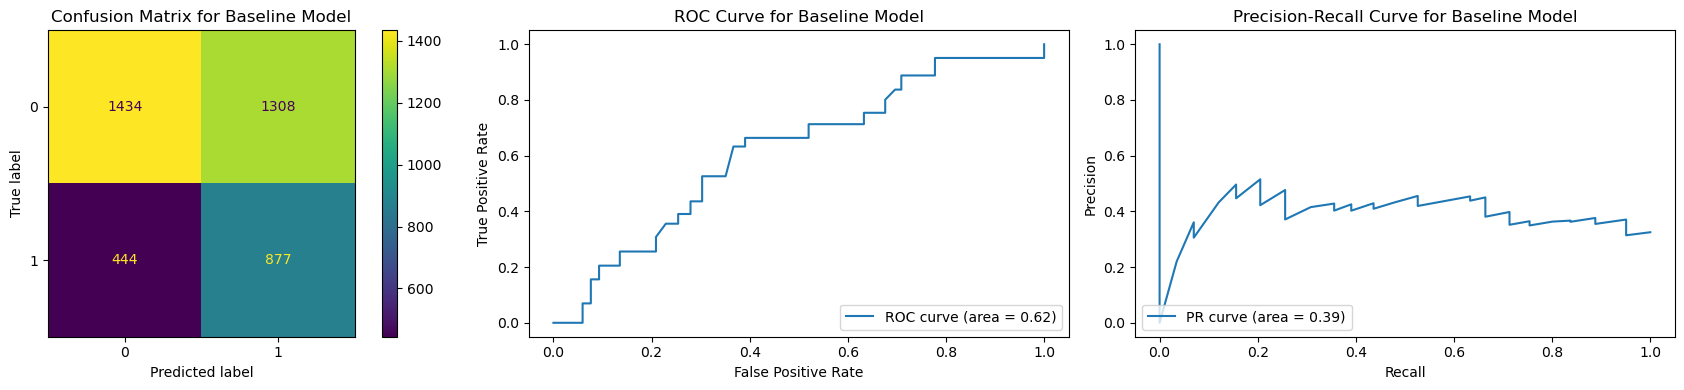

Cross Validation Scores for SMOTEN Oversampled Model:  [0.55687204 0.49555687 0.4637037  0.35881481 0.45837037]
Mean Cross Validation Recall for SMOTEN Oversampled Model: 0.4667

Test Classification Report for SMOTEN Oversampled Model
              precision    recall  f1-score   support

           0       0.81      0.51      0.63      2742
           1       0.43      0.75      0.55      1321

    accuracy                           0.59      4063
   macro avg       0.62      0.63      0.59      4063
weighted avg       0.69      0.59      0.60      4063



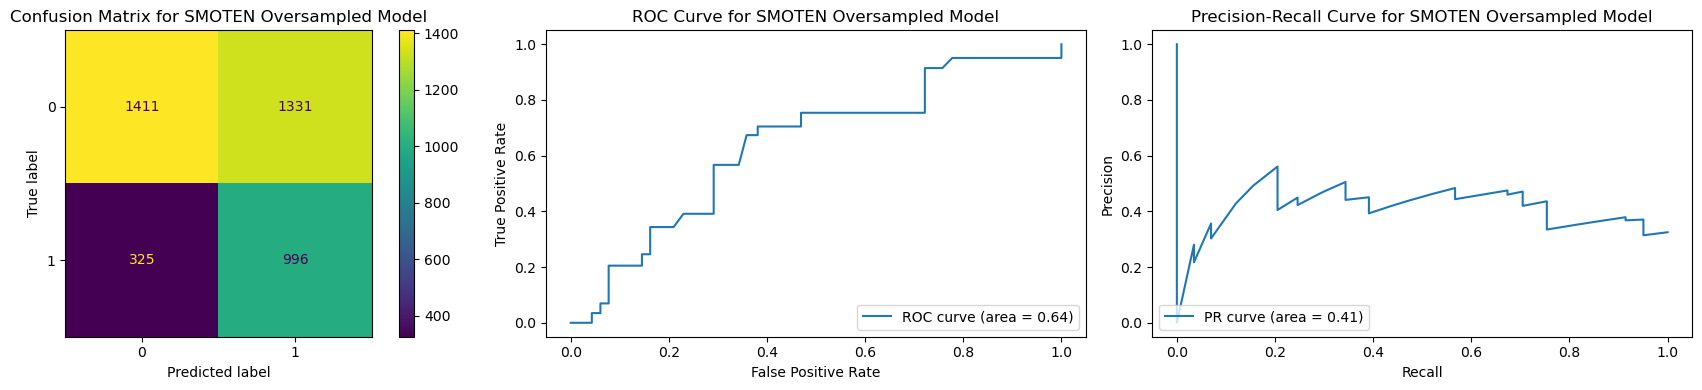

Cross Validation Scores for Undersampled Model:  [0.57197867 0.46001185 0.48948148 0.344      0.51881481]
Mean Cross Validation Recall for Undersampled Model: 0.4769

Test Classification Report for Undersampled Model
              precision    recall  f1-score   support

           0       0.78      0.50      0.61      2742
           1       0.41      0.70      0.52      1321

    accuracy                           0.57      4063
   macro avg       0.59      0.60      0.56      4063
weighted avg       0.66      0.57      0.58      4063



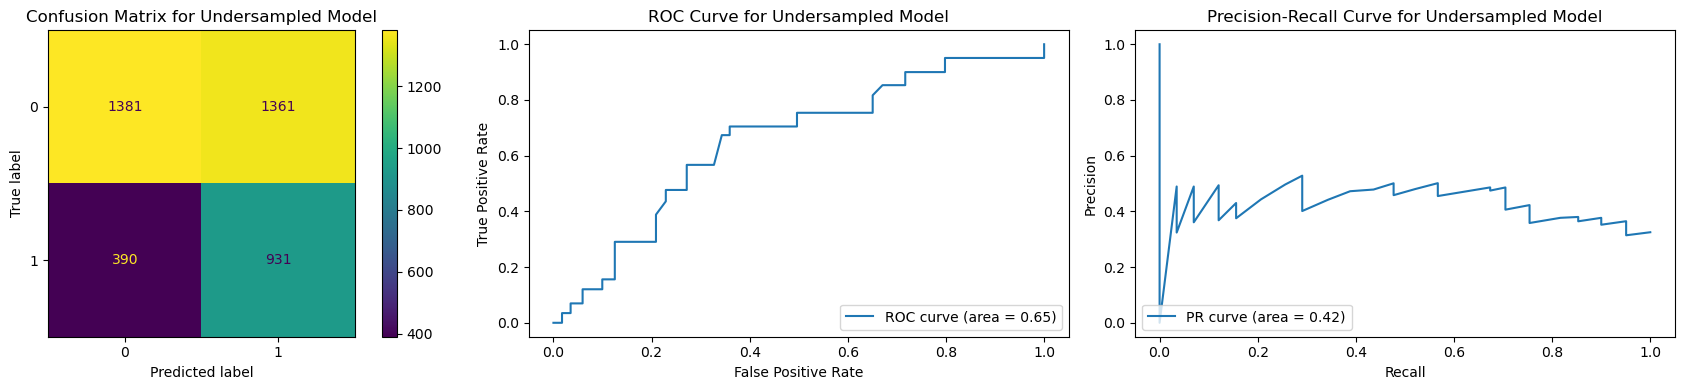

Cross Validation Scores for SMOTEN Oversampled+ Undersampled Model:  [0.55687204 0.49555687 0.4637037  0.35881481 0.45837037]
Mean Cross Validation Recall for SMOTEN Oversampled+ Undersampled Model: 0.4667

Test Classification Report for SMOTEN Oversampled+ Undersampled Model
              precision    recall  f1-score   support

           0       0.81      0.51      0.63      2742
           1       0.43      0.75      0.55      1321

    accuracy                           0.59      4063
   macro avg       0.62      0.63      0.59      4063
weighted avg       0.69      0.59      0.60      4063



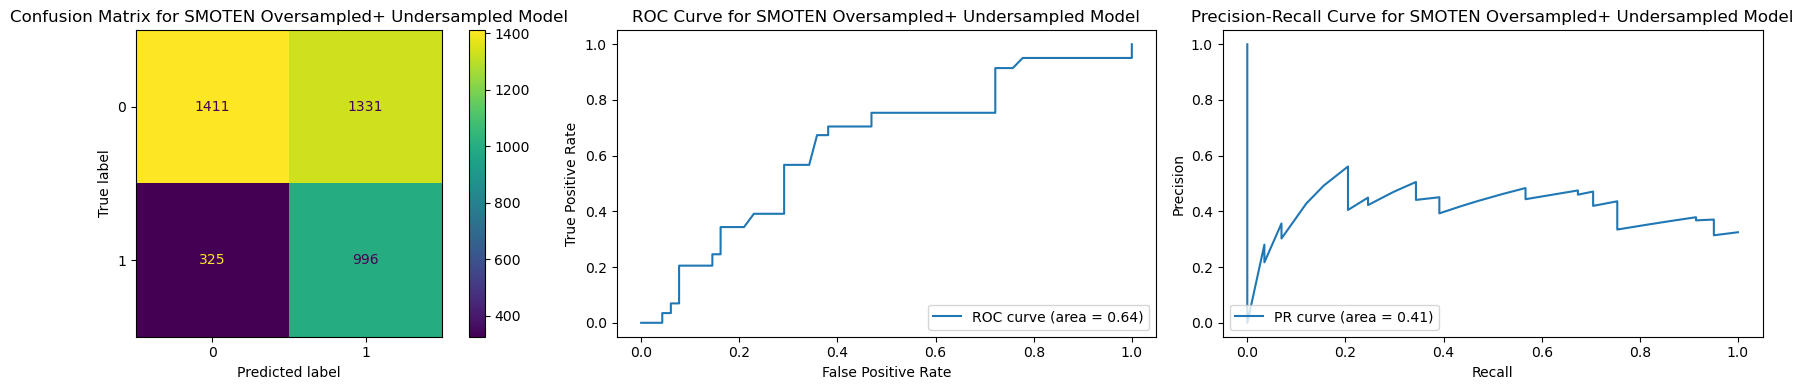

Cross Validation Scores for ADASYN Oversampled Model:  [0.53584123 0.51332938 0.53659259 0.38222222 0.62696296]
Mean Cross Validation Recall for ADASYN Oversampled Model: 0.5190

Test Classification Report for ADASYN Oversampled Model
              precision    recall  f1-score   support

           0       0.82      0.54      0.65      2742
           1       0.44      0.75      0.56      1321

    accuracy                           0.61      4063
   macro avg       0.63      0.65      0.60      4063
weighted avg       0.70      0.61      0.62      4063



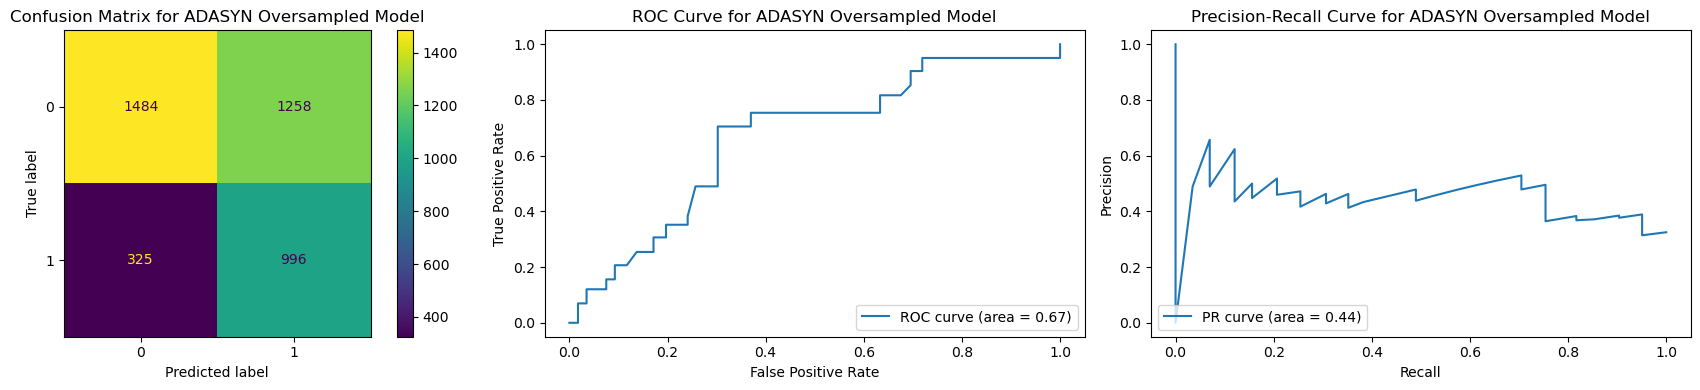

,Strategy,Mean CV Recall,Recall,Precision,F1 Score,ROC AUC,PR AUC
0,Baseline Model,0.443911,0.663891,0.401373,0.500285,0.615077,0.390037
1,SMOTEN Oversampled Model,0.466664,0.753974,0.428019,0.546053,0.637263,0.408379
2,Undersampled Model,0.476857,0.704769,0.406195,0.515361,0.650510,0.422635
3,SMOTEN Oversampled+ Undersampled Model,0.466664,0.753974,0.428019,0.546053,0.637263,0.408379
4,ADASYN Oversampled Model,0.518990,0.753974,0.441881,0.557203,0.665492,0.443410


In [8]:
# Initialize the XGBoost classifier 
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)

# Define the strategies to be evaluate
strategies = {
    'Baseline Model': [],
    'SMOTEN Oversampled Model': [('s', SMOTEN(sampling_strategy=1, random_state=42))],
    'Undersampled Model': [('s', RandomUnderSampler(sampling_strategy=1, random_state=42))],
    'SMOTEN Oversampled+ Undersampled Model': [
        ('o', SMOTEN(sampling_strategy=1, random_state=42)),
        ('u', RandomUnderSampler(sampling_strategy=1, random_state=42))
    ],
    'ADASYN Oversampled Model': [('s', ADASYN(sampling_strategy=1, random_state=42))]
}

results = []

for strategy_name, steps in strategies.items():
    # If the strategy list is not empty, create a pipeline
    if steps:
        pipeline = Pipeline(steps=steps + [('m', clone(xgb_model))])
    # If the strategy list is empty, use the model directly
    else:
        pipeline = clone(xgb_model)

    # Cross-validation scores with parallel processing
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
    mean_score = scores.mean()
    print(f'Cross Validation Scores for {strategy_name}: ', scores)
    print(f'Mean Cross Validation Recall for {strategy_name}: {mean_score:.4f}\n')

    # Fit the pipeline or model and make predictions
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    # Classification report
    print(f'Test Classification Report for {strategy_name}')
    report = classification_report(y_test, predictions, output_dict=True)
    print(classification_report(y_test, predictions))

    # ROC curve and Precision-Recall curve
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    # Set up the subplots for a more compact display of plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    axs[0].set_title(f'Confusion Matrix for {strategy_name}')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(ax=axs[0])

    # ROC curve
    axs[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title(f'ROC Curve for {strategy_name}')
    axs[1].legend(loc="lower right")

    # Precision-Recall curve
    axs[2].plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    axs[2].set_xlabel('Recall')
    axs[2].set_ylabel('Precision')
    axs[2].set_title(f'Precision-Recall Curve for {strategy_name}')
    axs[2].legend(loc="lower left")

    plt.tight_layout()  
    plt.show()

    # Store metrics 
    results.append({
        'Strategy': strategy_name,
        'Mean CV Recall': mean_score,
        'Recall': report['1']['recall'],
        'Precision': report['1']['precision'],
        'F1 Score': report['1']['f1-score'],
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc
    })

results_df = pd.DataFrame(results)
results_df


In [9]:

results_df

,Strategy,Mean CV Recall,Recall,Precision,F1 Score,ROC AUC,PR AUC
0,Baseline Model,0.443911,0.663891,0.401373,0.500285,0.615077,0.390037
1,SMOTEN Oversampled Model,0.466664,0.753974,0.428019,0.546053,0.637263,0.408379
2,Undersampled Model,0.476857,0.704769,0.406195,0.515361,0.650510,0.422635
3,SMOTEN Oversampled+ Undersampled Model,0.466664,0.753974,0.428019,0.546053,0.637263,0.408379
4,ADASYN Oversampled Model,0.518990,0.753974,0.441881,0.557203,0.665492,0.443410


All of the above models have similar metrics; they have decent recall, but have relatively low precision and CV scores. I will select the oversampled 'ADASYN' model as it has the best metrics, and see if hyperparameter tuning improves it.

## 5.6.2 Model Selection: ADASYN XGBoost Classifier <a id='5.6.2'></a>

Train the model, as the above code only returned metrics:

In [10]:
# Initialize the XGBoost classifier 
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)

# Create the ADASYN oversampling pipeline with the XGBoost classifier
xgb_adasyn = Pipeline([
    ('adasyn', ADASYN(sampling_strategy=1, random_state=42)),
    ('xgb', clone(xgb_model))
])

xgb_adasyn.fit(X_train, y_train)

Pipeline(steps=[('adasyn', ADASYN(random_state=42, sampling_strategy=1)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

## 5.6.3 Hyperparameter Tuning & Cross Checks <a id='5.6.3'></a>

Running the model without splitting household data has resulted in poorer model performance, so now I will try to improve it via hyperparameter tuning.

I will then look at the ROC and AUC curves, look at a correlation heat map, importance values, and permutation importance values. If the  model needs to be tweaked based on any of these results, I will do so. 

In [11]:
# Define XGBoost classifier and ADASYN oversampler
xgb_classifier = XGBClassifier(random_state=42)
adasyn_oversampler = ADASYN(sampling_strategy=1, random_state=42)

# Create a pipeline with ADASYN followed by XGBoost
pipeline = Pipeline([
    ('adasyn', adasyn_oversampler),
    ('xgb', xgb_classifier)
])

param_distributions = {
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__n_estimators': randint(50, 400),
    'xgb__subsample': uniform(0.7, 0.3),
    'xgb__colsample_bytree': uniform(0.7, 0.3)
}


random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                   n_iter=100, scoring='recall', cv=5, n_jobs=-1, 
                                   verbose=2, random_state=42)

random_search.fit(X_train, y_train)

best_parameters = random_search.best_params_

# The best model from RandomizedSearchCV
xgb_adasyn_tuned = random_search.best_estimator_



Fitting 5 folds for each of 100 candidates, totalling 500 fits


Run the Predictions and Metrics on the tuned model

Cross Validation Scores:  [0.72985782 0.75444313 0.63140741 0.54814815 0.74814815]
Mean CV Score:  0.6824009303142005
Test Classification Report, Tuned XGBoostClassifier() Model with Oversampling
              precision    recall  f1-score   support

           0       0.78      0.59      0.67      2742
           1       0.44      0.66      0.53      1321

    accuracy                           0.61      4063
   macro avg       0.61      0.62      0.60      4063
weighted avg       0.67      0.61      0.62      4063

Confusion Matrix: 


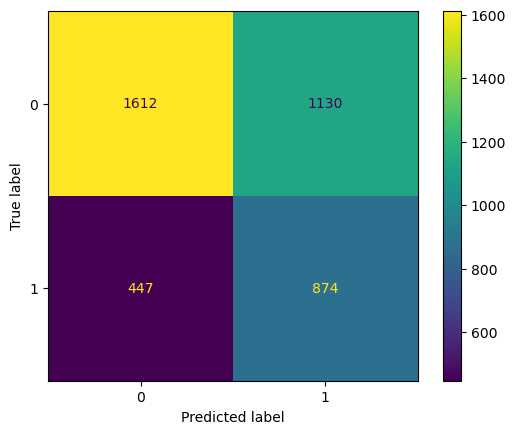

In [12]:
# Make predictions on the test set that was segmented by household_key
predictions_tuned = xgb_adasyn_tuned.predict(X_test)

# Calculate cross-validation scores on the oversampled training data
scores = cross_val_score(xgb_adasyn_tuned, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
mean_score = scores.mean()
print('Cross Validation Scores: ', scores)
print('Mean CV Score: ', mean_score)

# Classification report for the test set
print(f'Test Classification Report, Tuned XGBoostClassifier() Model with Oversampling')
print(classification_report(y_test, predictions_tuned))

# Confusion matrix for the test set
cm = confusion_matrix(y_test, predictions_tuned)
print(f'Confusion Matrix: ')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_adasyn_tuned.classes_).plot()
plt.show()


The CV score is much better now, but there are still tons of faste positives. 

### ROC and PR Curves for Tuned ADASYN Model

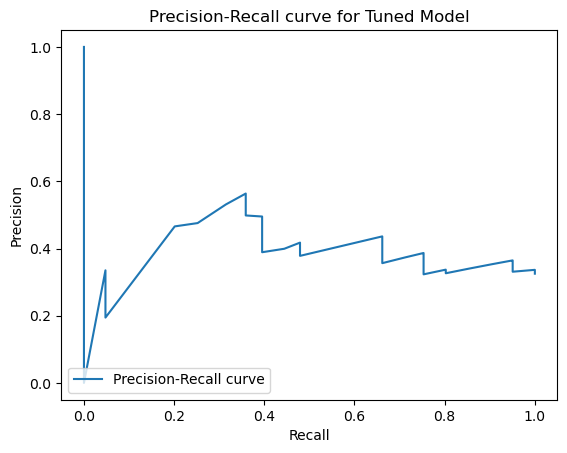

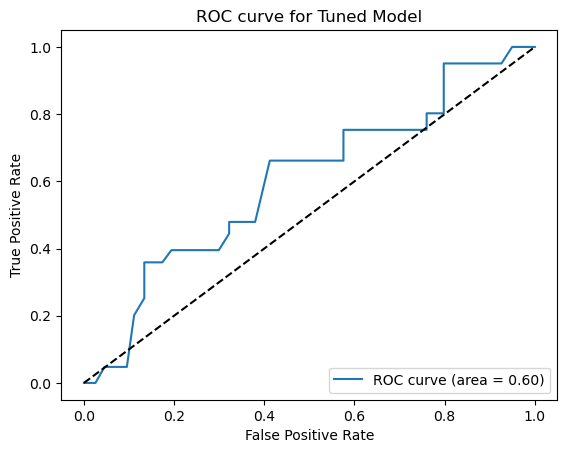

In [13]:
# Predict the probabilities for the positive class
y_scores_tuned = xgb_adasyn_tuned.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
precision_tuned, recall_tuned, thresholds_pr_tuned = precision_recall_curve(y_test, y_scores_tuned)

# Compute ROC curve and ROC area
fpr_tuned, tpr_tuned, thresholds_roc_tuned = roc_curve(y_test, y_scores_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_tuned, precision_tuned, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for Tuned Model')
plt.legend(loc="lower left")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr_tuned, tpr_tuned, label=f'ROC curve (area = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Tuned Model')
plt.legend(loc="lower right")
plt.show()


<b>I want to make sure that nothing strange is going on with my features, and to see if I can improve the model.</b>

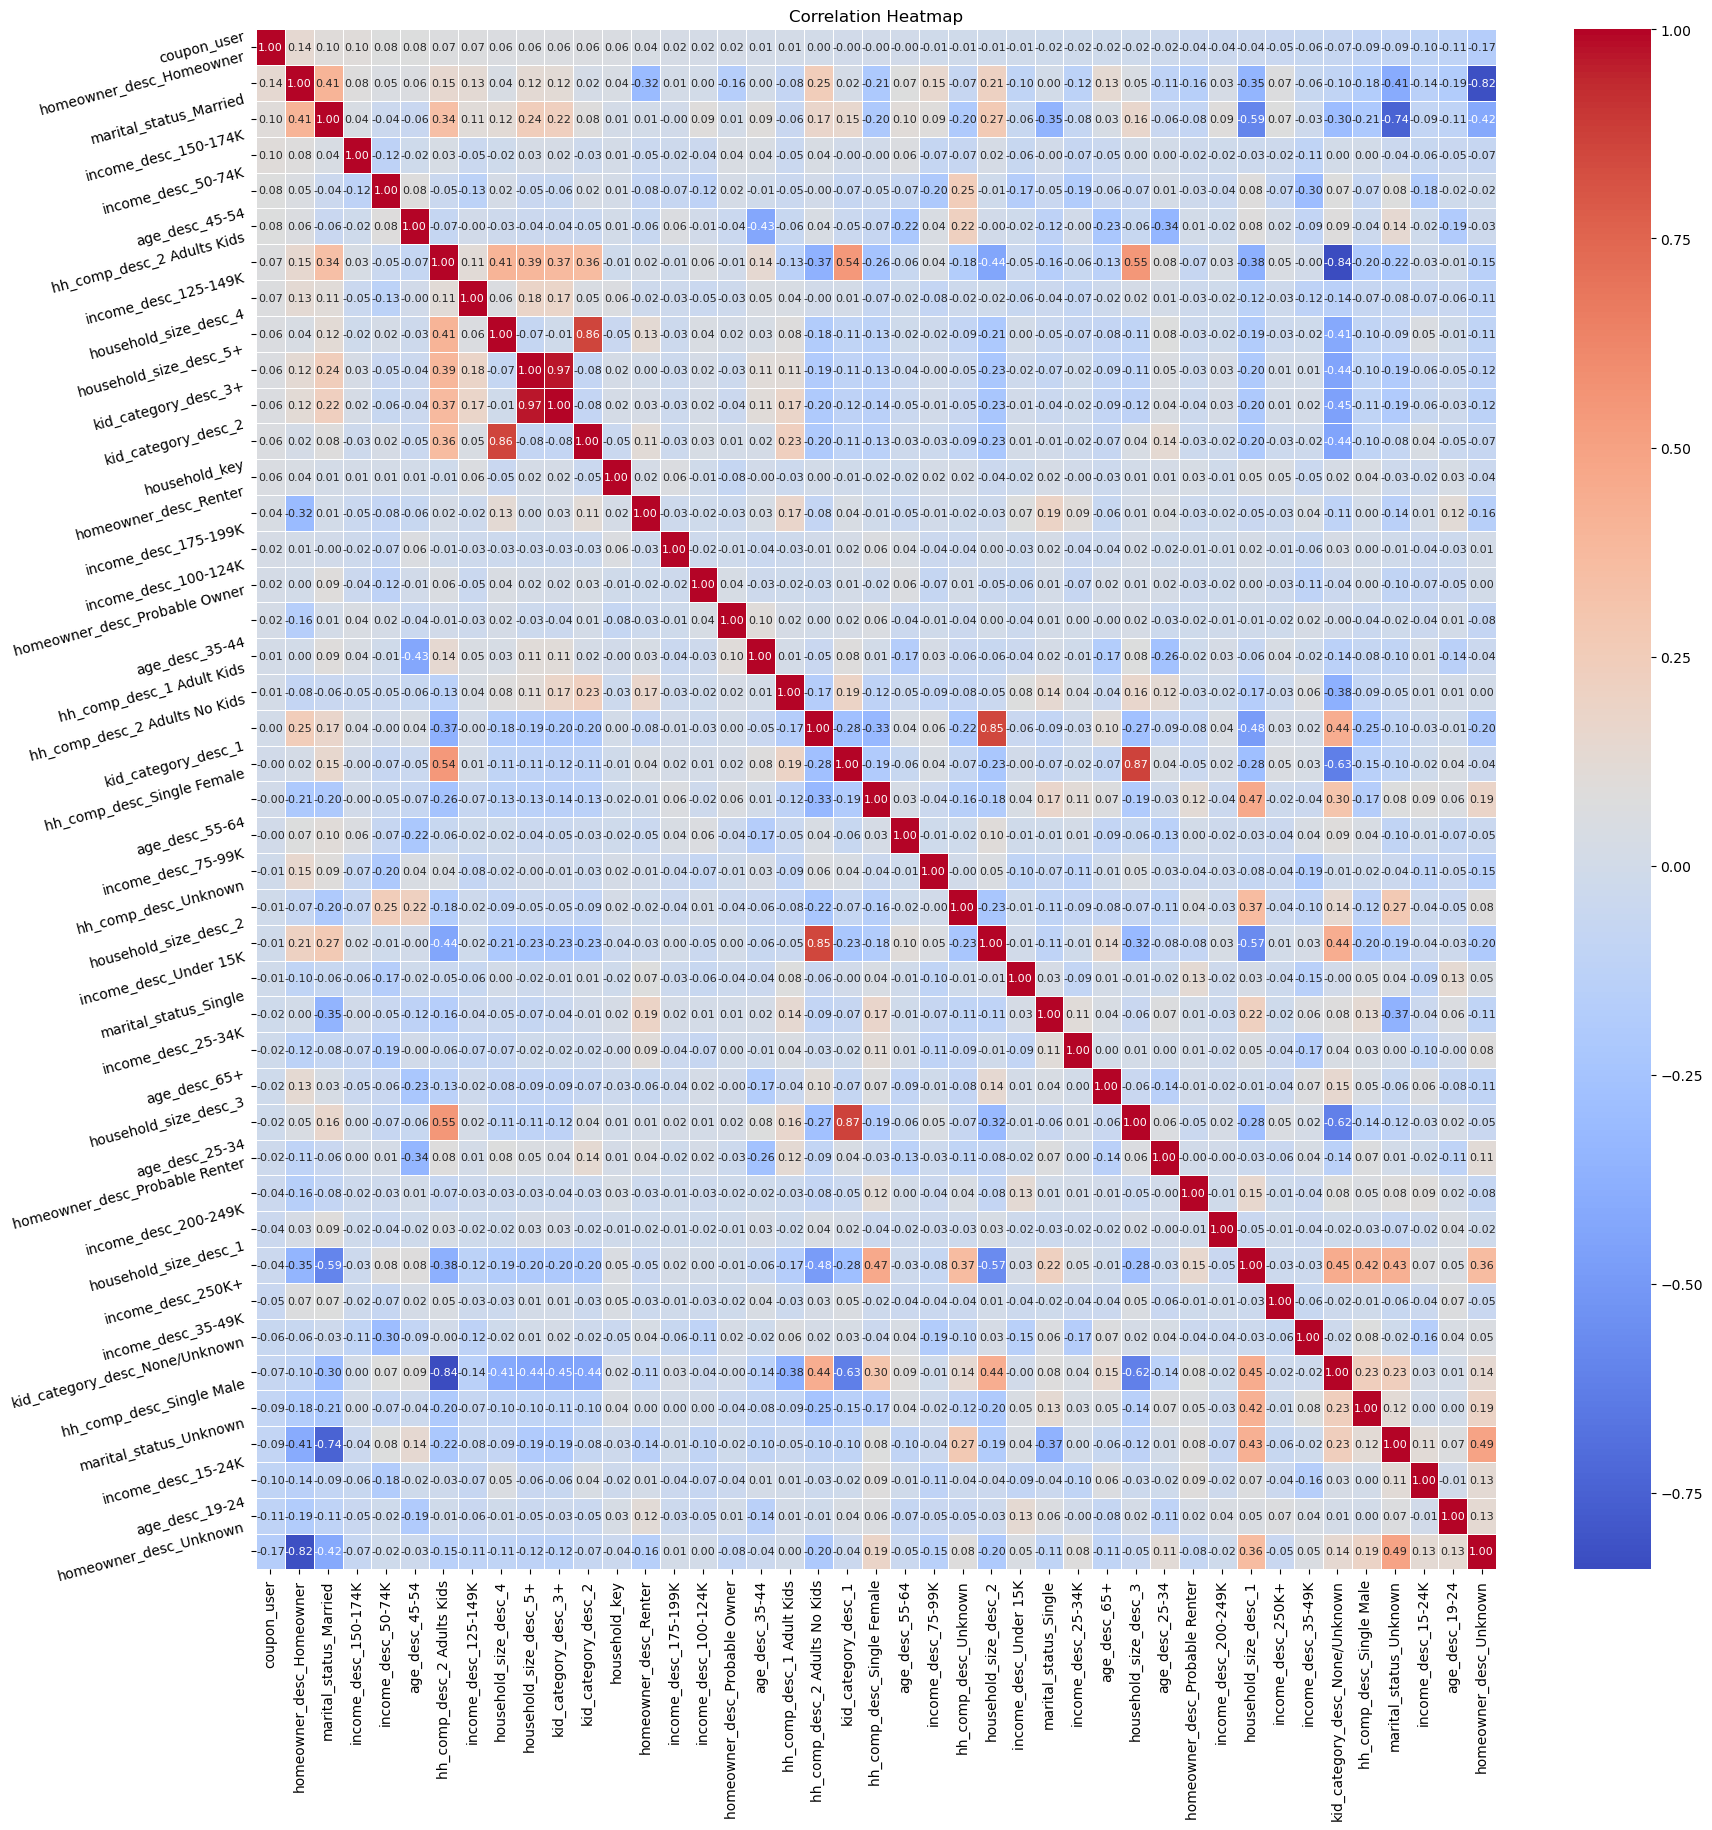

In [14]:
# Calculate the correlation matrix
corr_matrix = coupon_pred_data.corr()

sorted_corr = corr_matrix['coupon_user'].sort_values(ascending=False)

smaller_corr_matrix = corr_matrix.loc[sorted_corr.index, sorted_corr.index]

plt.figure(figsize=(20, 20))

sns.heatmap(smaller_corr_matrix, 
            annot=True,    
            cmap='coolwarm', 
            linewidths=.5,   
            fmt='.2f',       
            annot_kws={"size": 8})  

plt.yticks(rotation=15)  
plt.title('Correlation Heatmap')
plt.show()

There are some takeaways I could have guessed here - household sizes over 2 are correlated with kids, 1 person households are correlated with single males, unknown marital status, and incomes 15-24K, single males are negatively correlated with 2 adult households with kids.

In [15]:
# Get correlations of 'coupon_user' with other variables
correlations = corr_matrix['coupon_user'].sort_values(ascending=False)

# Print the features that are most positively correlated with 'coupon_user'
print("Top 5 positively correlated features with coupon users:")
correlations.head(6)

Top 5 positively correlated features with coupon users:


coupon_user                 1.000000
homeowner_desc_Homeowner    0.143165
marital_status_Married      0.100703
income_desc_150-174K        0.098436
income_desc_50-74K          0.077438
age_desc_45-54              0.075533
Name: coupon_user, dtype: float64

In [16]:
print("\nTop 5 negatively correlated features with coupon users:")
correlations.tail(5)


Top 5 negatively correlated features with coupon users:


hh_comp_desc_Single Male   -0.087901
marital_status_Unknown     -0.088435
income_desc_15-24K         -0.101973
age_desc_19-24             -0.113024
homeowner_desc_Unknown     -0.166916
Name: coupon_user, dtype: float64

There aren't features strongly correlated with coupon use on their own.

<b> Feature Importance</b>

The below plot will tell us how important each feature is in the construction of the boosted decision tree.

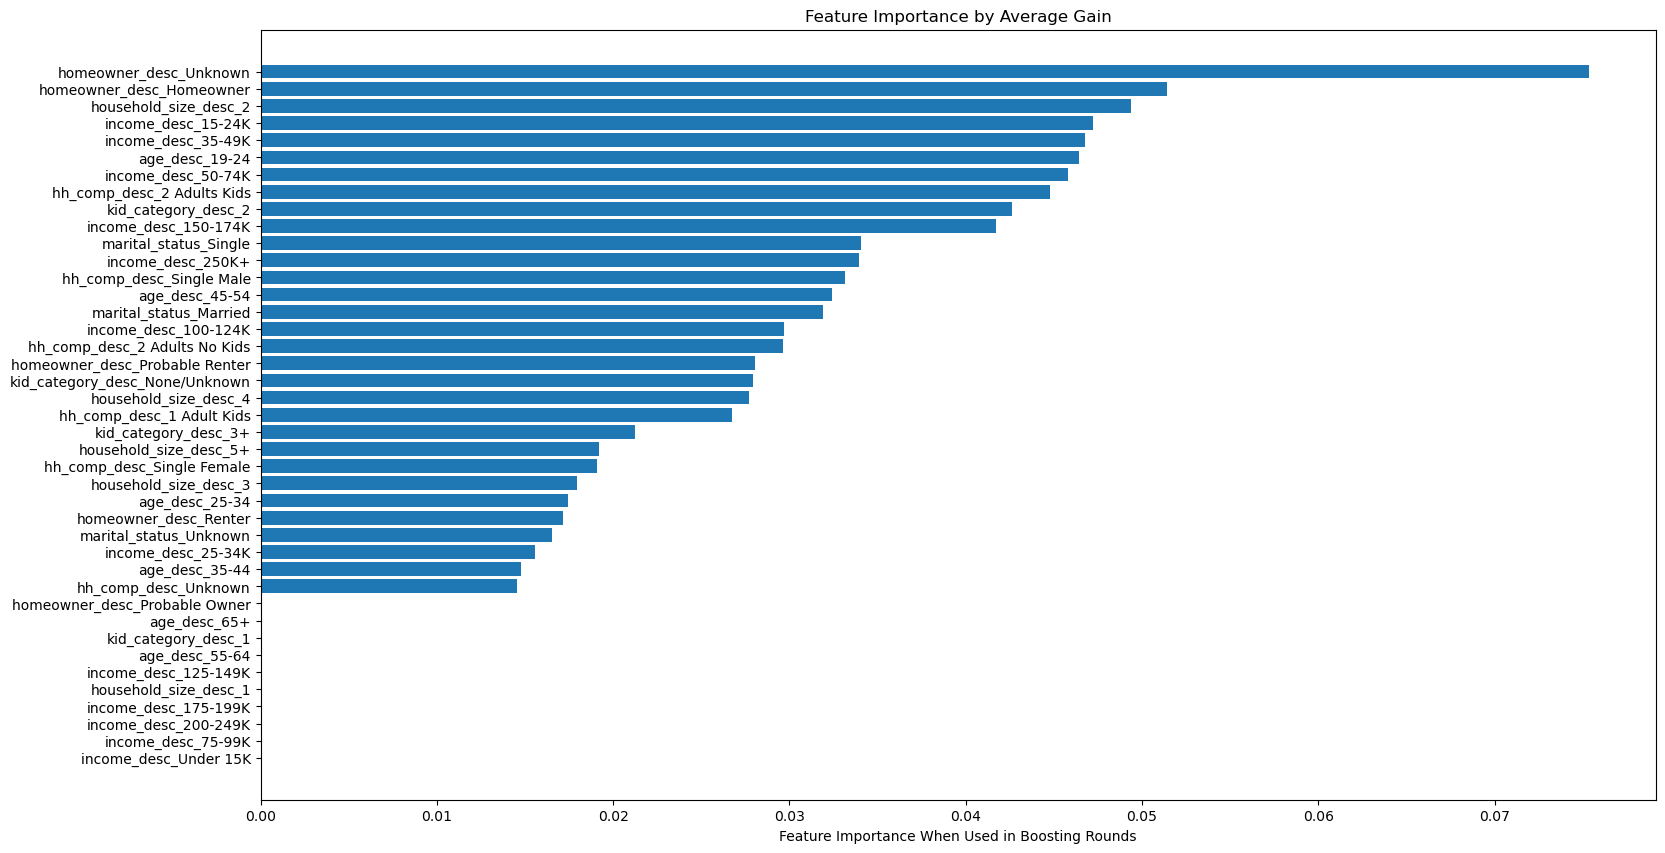

In [17]:
feature_importance = xgb_adasyn_tuned.named_steps['xgb'].feature_importances_

sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(18,10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance by Average Gain')
plt.xlabel('Feature Importance When Used in Boosting Rounds')
plt.show()


'Unknown' homeowner status is by far the most important feature, followed by homeowners, household size of 2, and lower income and age brackets.

<b>Permutation Importance</b>

Which features improve model performance, and which ones worsen it?


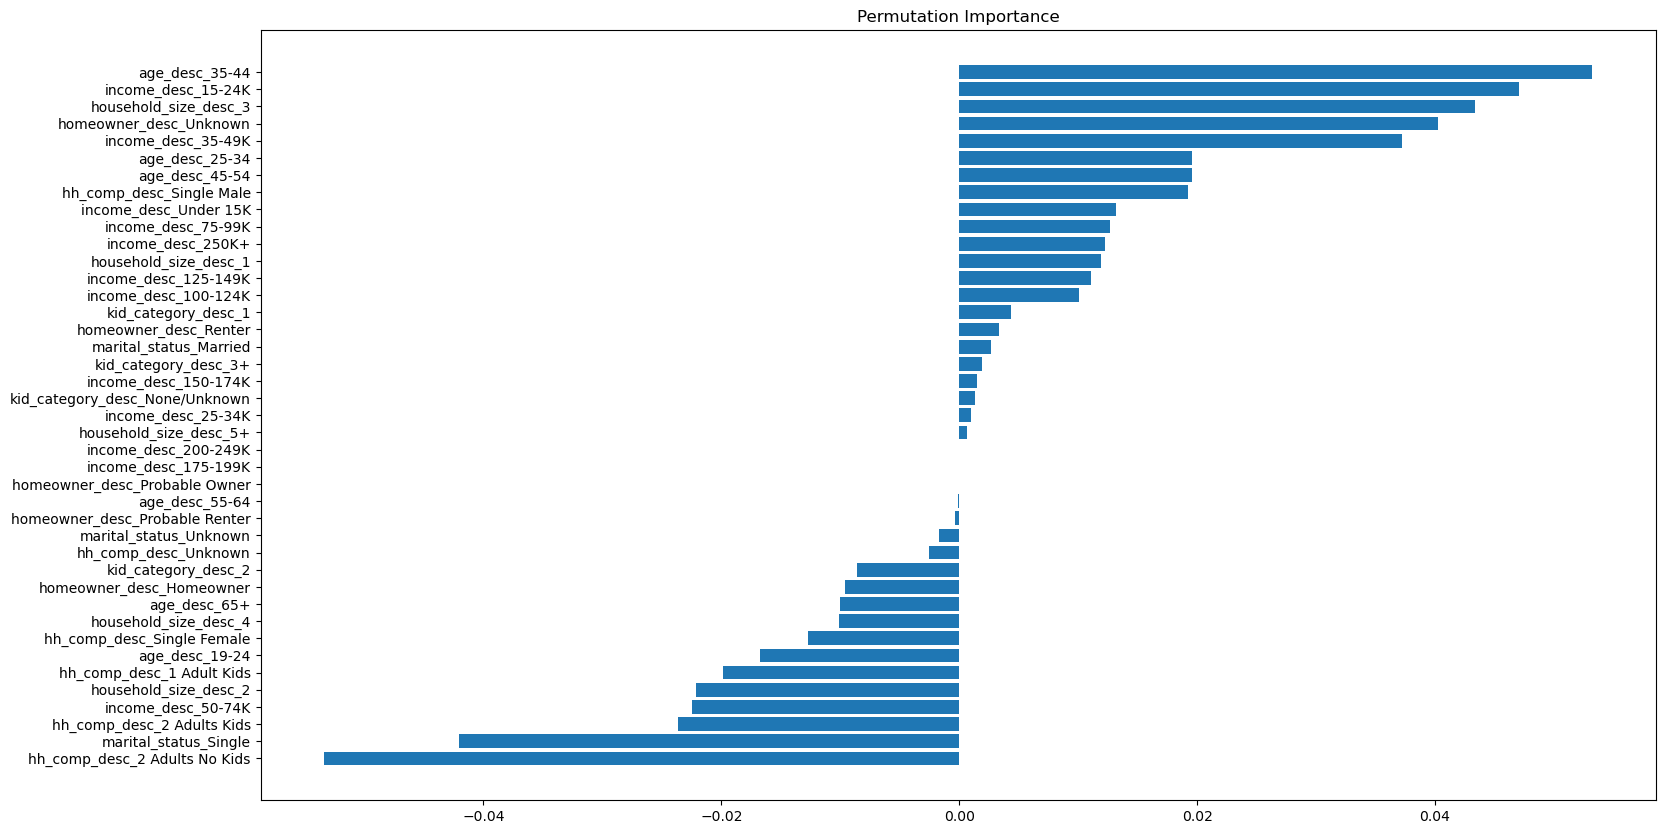

In [18]:
# Calculate permutation importance
perm_importance = permutation_importance(xgb_adasyn.named_steps['xgb'], X_test, y_test, n_jobs=-1)

# Sort the features by importance
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
fig = plt.figure(figsize=(18, 10))
plt.barh(range(X_test.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.title('Permutation Importance')
plt.show()


Interestingly, some of the features with negative permutation importance had the highest importance values in the previous block! This includes homeowners, household size of 2, and age 19-24.

I'd like to try to drop the features with negative permutation values, and re-run the model.

I don't want to do this for the SHAP analysis later, but it could be helpful for improving my predictive model.

Cross Validation Scores:  [0.4653436  0.54887441 0.45214815 0.44296296 0.64562963]
Mean CV Score:  0.5109917500438828
Test Classification Report, Tuned XGBoostClassifier() Model with Reduced Features
              precision    recall  f1-score   support

           0       0.76      0.52      0.62      2742
           1       0.40      0.65      0.49      1321

    accuracy                           0.56      4063
   macro avg       0.58      0.59      0.55      4063
weighted avg       0.64      0.56      0.58      4063

Confusion Matrix: 


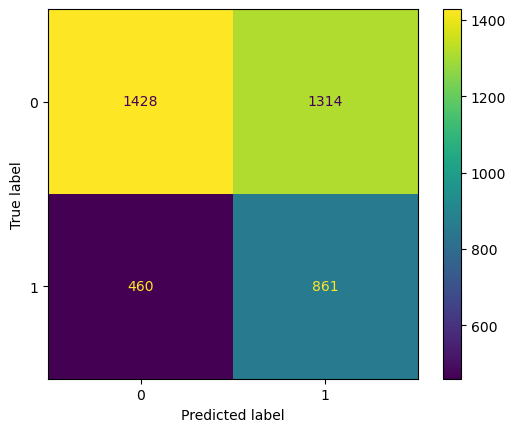

In [19]:
# Identify negative permutation importance features
negative_features = X_test.columns[perm_importance.importances_mean < 0]

# Remove negative importance features from the dataset
X_train_reduced = X_train.drop(negative_features, axis=1)
X_test_reduced = X_test.drop(negative_features, axis=1)

# Fit and Predict
xgb_adasyn.fit(X_train_reduced, y_train)
predictions_tuned_reduced = xgb_adasyn.predict(X_test_reduced)

# CV scores
scores_reduced = cross_val_score(xgb_adasyn, X_train_reduced, y_train, cv=5, scoring='recall', n_jobs=-1)
mean_score_reduced = scores_reduced.mean()
print('Cross Validation Scores: ', scores_reduced)
print('Mean CV Score: ', mean_score_reduced)

# Classification report
print(f'Test Classification Report, Tuned XGBoostClassifier() Model with Reduced Features')
print(classification_report(y_test, predictions_tuned_reduced))

# Confusion matrix
cm_reduced = confusion_matrix(y_test, predictions_tuned_reduced)
print(f'Confusion Matrix: ')
ConfusionMatrixDisplay(confusion_matrix=cm_reduced, display_labels=xgb_adasyn.classes_).plot()
plt.show()



This isn't better, so let's do some hyperparemeter tuning.

<b> Hyperparameter Tuning </b>

In [20]:
xgb_classifier = XGBClassifier(random_state=42)
adasyn_oversampler = ADASYN(sampling_strategy=1, random_state=42)

# Create a pipeline with ADASYN followed by XGBoost
pipeline = Pipeline([
    ('adasyn', adasyn_oversampler),
    ('xgb', xgb_classifier)
])

# Define the hyperparameter space
param_distributions = {
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__n_estimators': randint(50, 400),
    
    
    'xgb__subsample': uniform(0.7, 0.3),
    'xgb__colsample_bytree': uniform(0.7, 0.3)
}

random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                   n_iter=100, scoring='recall', cv=5, n_jobs=-1, 
                                   verbose=2, random_state=42)

random_search.fit(X_train_reduced, y_train)

best_parameters = random_search.best_params_

# The best model from RandomizedSearchCV
xgb_adasyn_tuned_reduced = random_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Cross Validation Scores:  [0.74022512 0.80598341 0.65896296 0.74192593 0.78133333]
Mean CV Score:  0.7456861506055819
Test Classification Report, Tuned XGBoostClassifier() Model with Oversampling
              precision    recall  f1-score   support

           0       0.76      0.44      0.56      2742
           1       0.38      0.72      0.50      1321

    accuracy                           0.53      4063
   macro avg       0.57      0.58      0.53      4063
weighted avg       0.64      0.53      0.54      4063



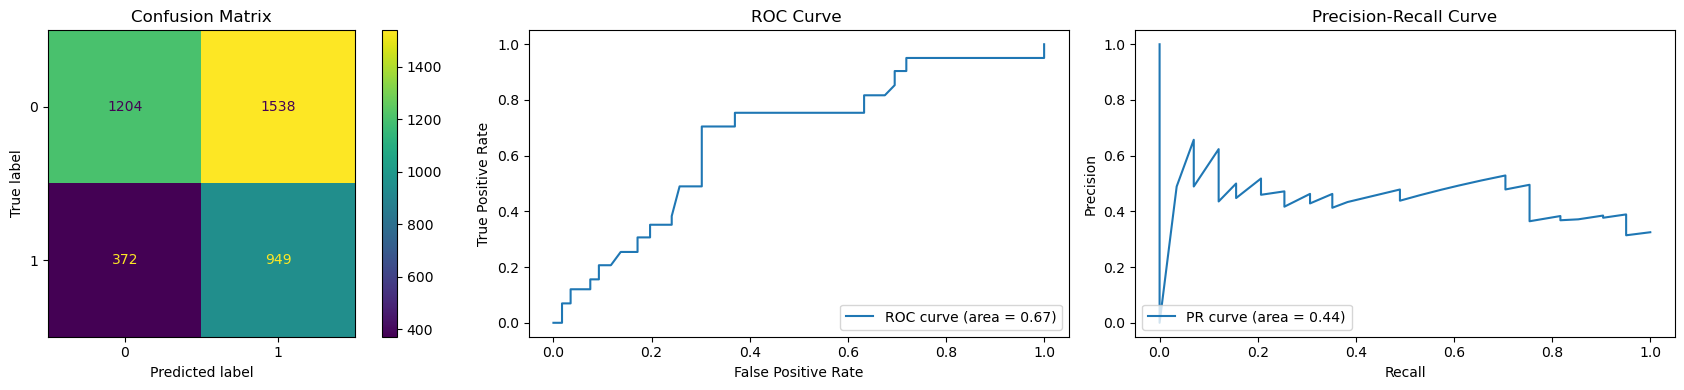

In [22]:
# Make predictions on the test set that was segmented by household_key
predictions_tuned = xgb_adasyn_tuned_reduced.predict(X_test_reduced)

# Calculate cross-validation scores on the oversampled training data
scores = cross_val_score(xgb_adasyn_tuned, X_train_reduced, y_train, cv=5, scoring='recall', n_jobs=-1)
mean_score = scores.mean()
print('Cross Validation Scores: ', scores)
print('Mean CV Score: ', mean_score)

# Classification report
print(f'Test Classification Report, Tuned XGBoostClassifier() Model with Oversampling')
print(classification_report(y_test, predictions_tuned))

# Set up the subplots for a more compact display of plots
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

# Confusion matrix
cm = confusion_matrix(y_test, predictions_tuned)
axs[0].set_title(f'Confusion Matrix')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(ax=axs[0])

# ROC curve
axs[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title(f'ROC Curve ')
axs[1].legend(loc="lower right")

# Precision-Recall curve
axs[2].plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
axs[2].set_xlabel('Recall')
axs[2].set_ylabel('Precision')
axs[2].set_title(f'Precision-Recall Curve')
axs[2].legend(loc="lower left")

plt.tight_layout()  
plt.show()

This is much better! With oversampling and removing the features that negatively impact importance, I now have a model that can correctly identify coupon users about 75% of the time. It is not very precise, and there are a lot of false positives, but it is better to send out too many coupons than to miss sales opportunities. 

## 5.7 Export Model <a id='5.7'></a>

I am happy with this predictive model where the negative permutation features where removed, and will now export it. 

In [23]:
# Rename model
coupon_prediction_model = xgb_adasyn_tuned_reduced

# Export
with open('C:/Users/leann/OneDrive/Desktop/SPRINGBOARD/Capstone 3/Final results/coupon_prediction_model.pkl', 'wb') as file:
    pickle.dump(coupon_prediction_model, file)

## 5.8 Build Model for SHAP Analysis <a id='5.8'></a>
Up to this point, I have built a model to predict coupon use, but now I would like to find out how the different features contribute towards whether or not a customer will use coupons. 

I will start with my coupon_pred_data table from the beginning of the notebook, before I removed the features that made the model perform worse. I am doing this because I am interested in feature interactions. 

I am building a model on the entire dataset, without a train test split, because I am not interested in predicting anything right now, but on interpreting how features contribute to coupon useage. However, I still need to be able to perform some sort of cross validation, so I will be using bootstrapping to mimic the 'Out of Bag' approach used with Random Forest. 

### Split the data into target and features & build baseline model

In [24]:
X = coupon_pred_data.drop(columns=['household_key','coupon_user'], axis=1)
y = coupon_pred_data['coupon_user']

In [25]:
n_iterations = 100
oob_scores = []

for i in range(n_iterations):
    # Bootstrap sample and OOB indices
    bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
    oob_indices = np.array([i for i in range(len(X)) if i not in bootstrap_indices])

    # Split the data into a bootstrap sample and an out-of-bag sample
    bootstrap_X = X.iloc[bootstrap_indices]
    bootstrap_y = y.iloc[bootstrap_indices]
    oob_X = X.iloc[oob_indices]
    oob_y = y.iloc[oob_indices]

    # Initialize and train the XGBoost model on the bootstrap sample
    model = xgb.XGBClassifier(random_state=42, n_jobs=-1)
    model.fit(bootstrap_X, bootstrap_y)

    # Predict and calculate error on the OOB sample
    oob_preds = model.predict(oob_X)
    oob_error = np.mean(oob_preds != oob_y)
    oob_scores.append(oob_error)

# Average the OOB scores
oob_score = np.mean(oob_scores)
print(f'Estimated OOB score: {oob_score:.3f}')


Estimated OOB score: 0.143


This estimated out of bag score is actually quite good, and indicates that we have an error rate of about 14%.

Now I will do some hyperparameter tuning:

In [27]:
param_grid = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'xgbclassifier__n_estimators': [100, 200, 300, 400, 500],
    'xgbclassifier__max_depth': [3, 4, 5, 6, 7],
    'xgbclassifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'xgbclassifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Create a pipeline with only the XGBClassifier
pipeline = make_pipeline(XGBClassifier())

# Setup the RandomizedSearchCV with k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=50, scoring='recall', cv=kfold, verbose=1, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV using the resampled data
random_search.fit(X_resampled, y_resampled)

# Retrieve the best model
full_classification_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

# Print the best mean cross-validation score
print("Best mean CV recall score:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'xgbclassifier__subsample': 0.9, 'xgbclassifier__n_estimators': 400, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__colsample_bytree': 0.7}
Best mean CV recall score: 0.9501346102399036


The tuned model has an excellent CV recall score of 93%, so I will proceed with this model.

### 5.9 SHAP Analysis <a id='5.9'></a>

Now I will perform SHAP analysis on my entire dataset, to find out which features contribute towards coupon use, and if we should pay attention to certain feature interactions.

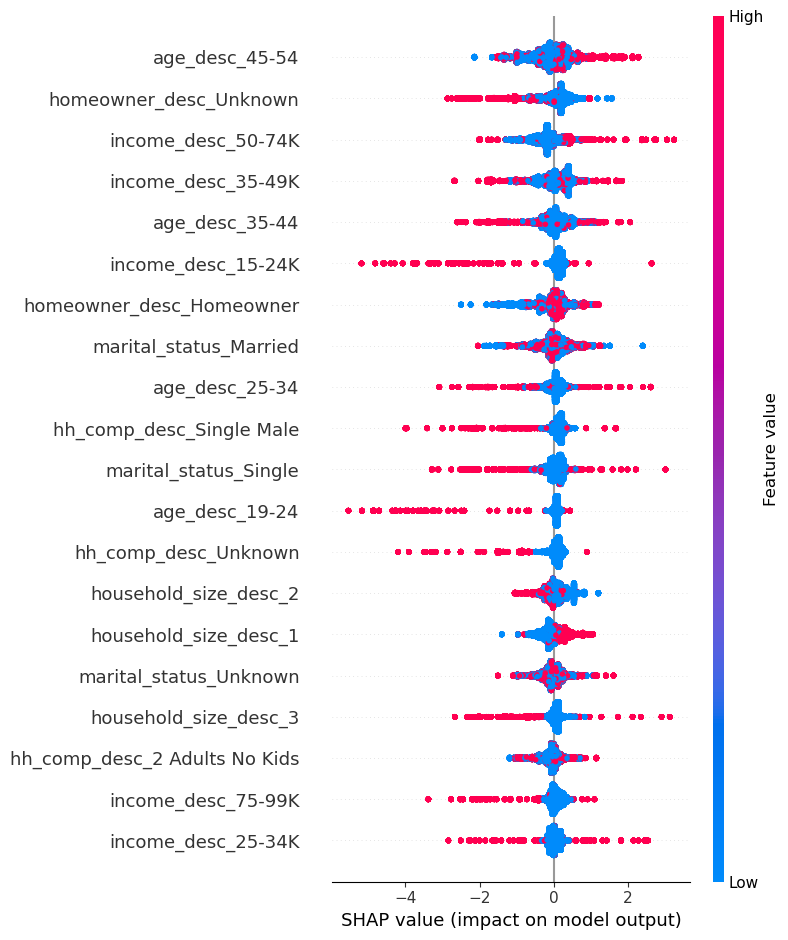

In [28]:
explainer = shap.Explainer(full_classification_model.named_steps['xgbclassifier'])
shap_values = explainer.shap_values(X)

# Create a SHAP beeswarm plot to show the impact of the top features
shap.summary_plot(shap_values, X)


Above we can see that that most of the features contribute fairly evently towards both coupon use and no coupon use, and there aren't many features that universally contribute very much towards coupon use. However, there are more that contribute towards <b>not</b> using coupons.  

<b>Features that contribute towards coupon use:</b>

* Ages 45-54 
* Homeowners
* Household size of 1

<b>Features that contribute <i>against</i> coupon use:</b>

* ‘Unknown’ homeowner status
* Income 15-24K
* Single males
* 19-24 year olds
* ‘Unknown’ household composition
* Household size of 2


Now look at the SHAP interaction plots for individual features:

In [29]:
# Extract the XGBClassifier model from the pipeline
xgb_model = full_classification_model.named_steps['xgbclassifier']

# Create a TreeExplainer with the extracted XGBClassifier model
explainer = shap.TreeExplainer(xgb_model, n_jobs=-1)

# Compute SHAP values
shap_values = explainer.shap_values(X)

# Calculate the mean absolute SHAP value for each feature
feature_importance = np.mean(np.abs(shap_values), axis=0)

# Get the names of the features from the column names of the dataset
feature_names = X.columns

# Create a DataFrame of the feature names and importance
importance_df = pd.DataFrame(list(zip(feature_names, feature_importance)), 
                              columns=['Feature','Importance'])

# Sort the DataFrame in descending order of importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Filter for importance values greater than 0
importance_df = importance_df[importance_df['Importance'] > 0]

# Display the top 20 features
importance_df.head(20)


,Feature,Importance
3,age_desc_45-54,0.442898
25,homeowner_desc_Unknown,0.416354
18,income_desc_50-74K,0.373590
17,income_desc_35-49K,0.367926
2,age_desc_35-44,0.345512
11,income_desc_15-24K,0.344020
21,homeowner_desc_Homeowner,0.328089
6,marital_status_Married,0.312629
1,age_desc_25-34,0.294148
30,hh_comp_desc_Single Male,0.290511


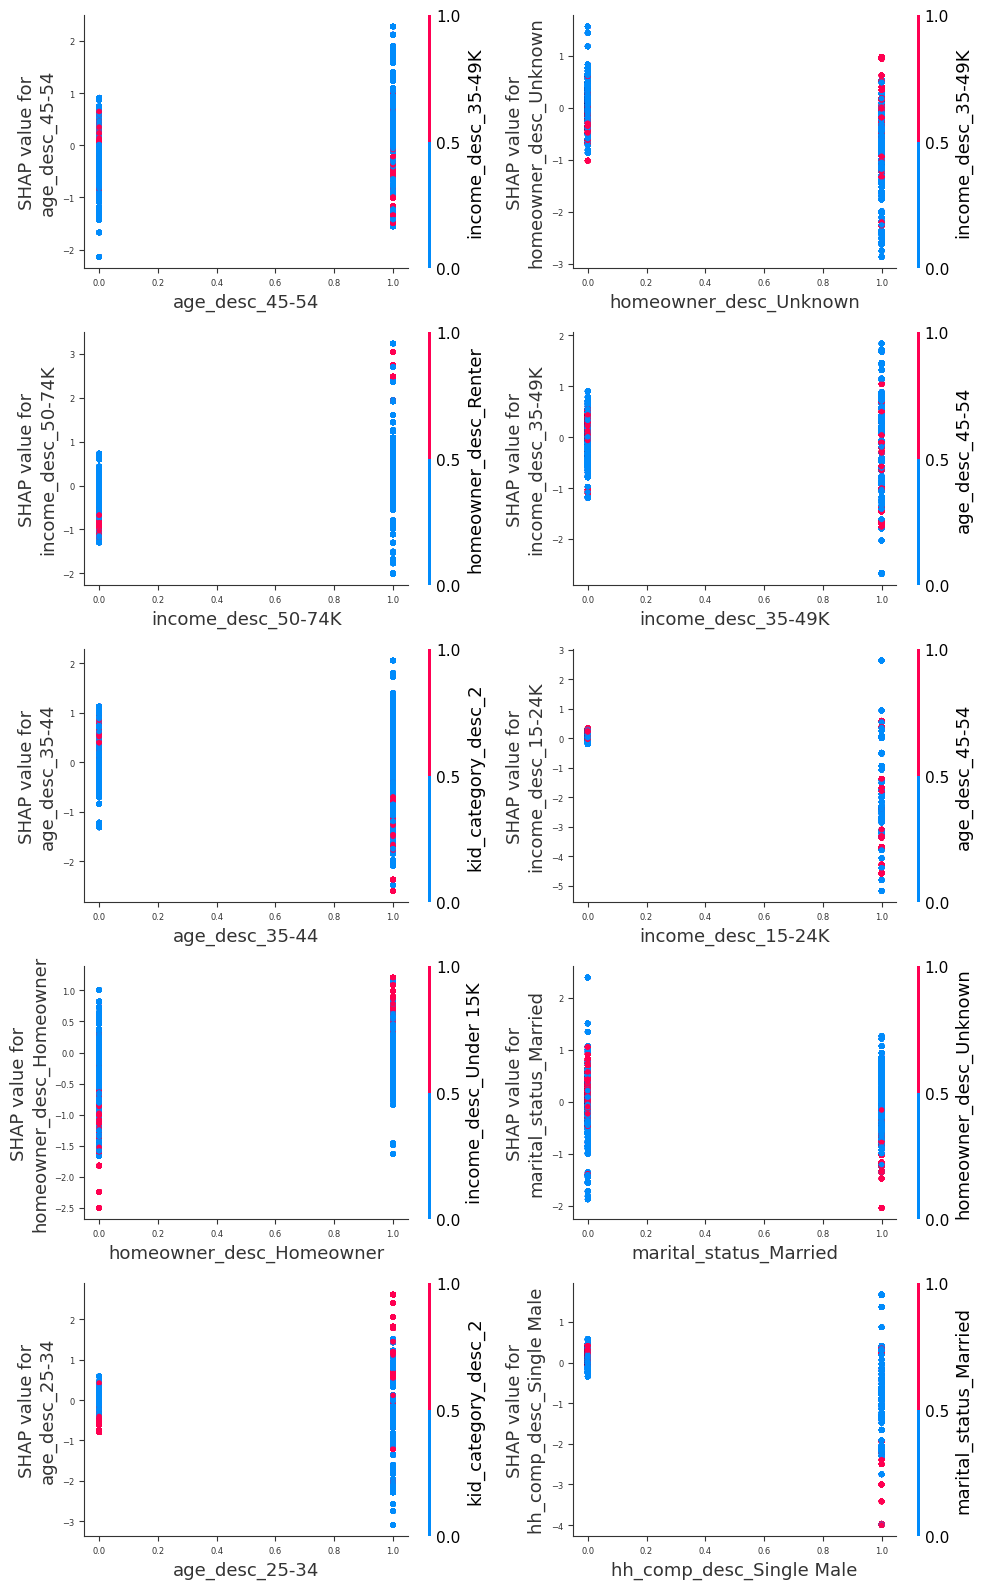

In [30]:
# Divide up our features into 2 code blocks to avoid formatting issues:

# Get the top 10 features from importance_df
top_features_1_10 = importance_df['Feature'].head(10)

# Create a grid of subplots: 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the top 10 features and create a SHAP dependence plot for each on its respective subplot
for i, feature in enumerate(top_features_1_10):
    shap.dependence_plot(feature, shap_values, X, ax=axes[i], show=False)
    axes[i].tick_params(axis='both', which='major', labelsize=6)  # Adjust fontsize of axis labels

# Adjust layout and spacing between subplots
plt.tight_layout()


plt.show();

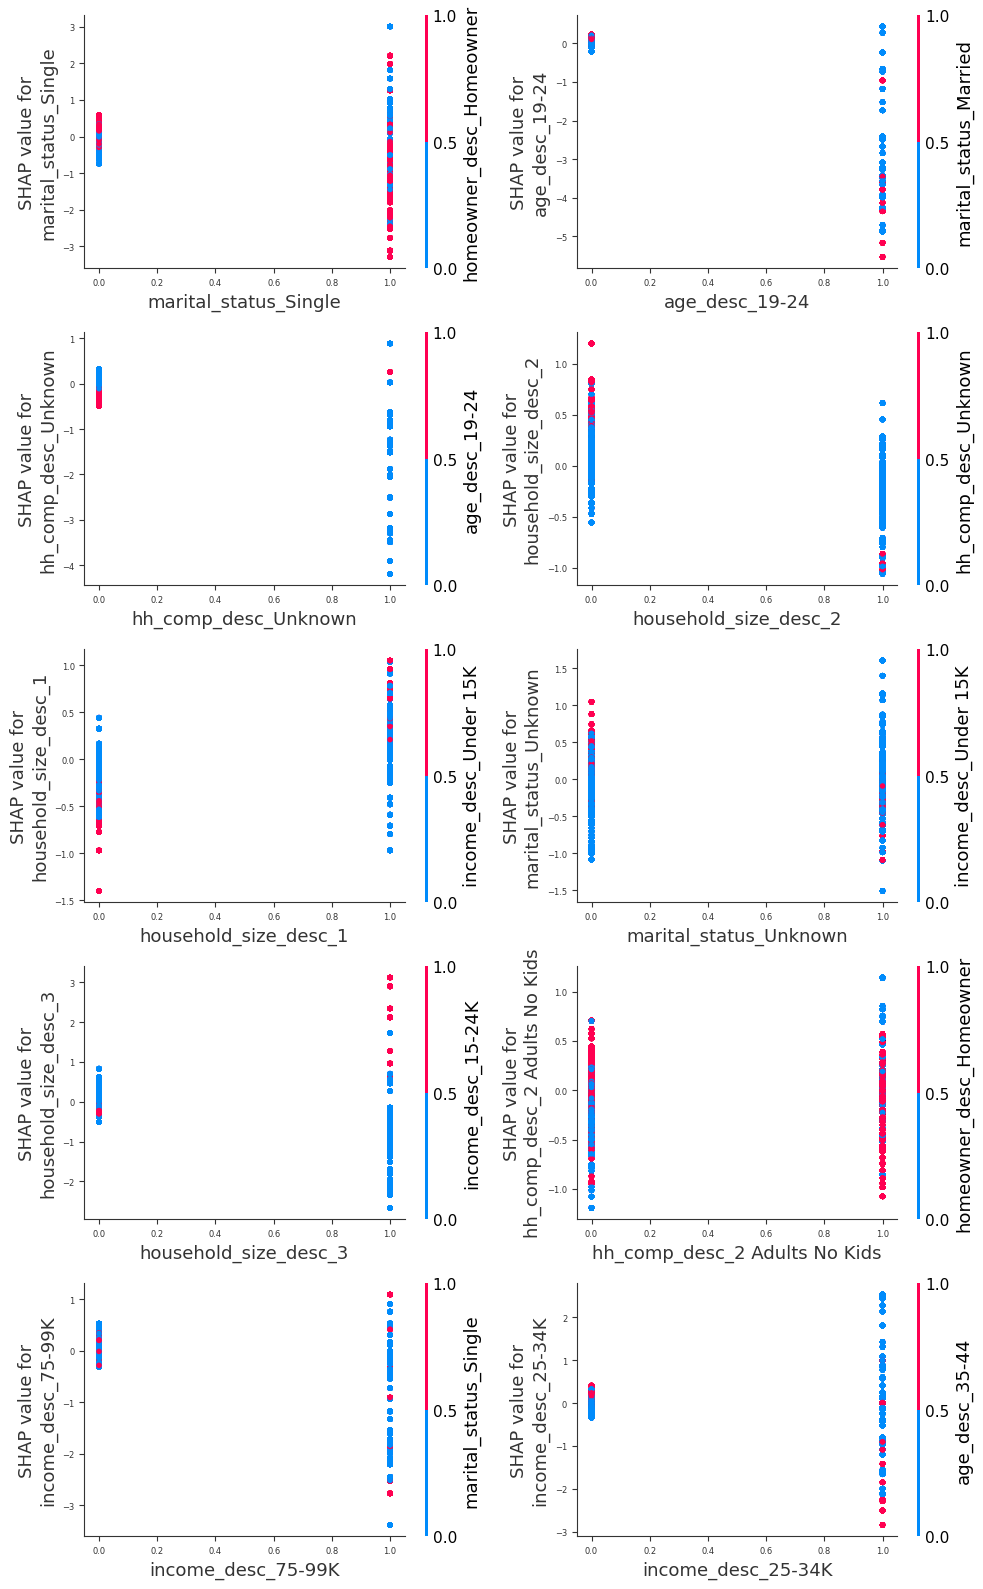

In [31]:
# Next 10 dependence plots: 

# Get features 11-20 from importance_df
top_features_11_20 = importance_df['Feature'][10:20]

# Create a grid of subplots: 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through features 11-20 and create a SHAP dependence plot for each on its respective subplot
for i, feature in enumerate(top_features_11_20):
    shap.dependence_plot(feature, shap_values, X, ax=axes[i], show=False)
    axes[i].tick_params(axis='both', which='major', labelsize=6)  # Adjust fontsize of axis labels

plt.tight_layout()

plt.show()


Here I was able to identify which feature interactions contribute towards and against coupon use: 

<b>Contribute towards coupon use:</b>

* Income 50-74K who are renters
* Homeowners who make under 15K
* Ages 25-34 with 2 kids
* Household size of 1 who make under 15K
* Household size of 3 who make 15-24K

<b>Contribute against coupon use:</b>
* Ages 45-54 who make 35-49K a year 
* Ages 35-44 with 2 kids
* Income 15-24K within the age bracket 45-54
* Married people with unknown homeowner status
* Single homeowners
* Income 15-34K who are age 35-44


## 5.10 Discussion <a id='5.10'></a>

In this notebook I built an XGBoost Classification model with ADASYN oversampling, where the features with negative permutation importance where removed. This model correctly predicts that a customer will use a coupon 75% of the time, with a mean cross validation score of 72%. As these values are close to each other, I'm not concerned with overfitting. It is important to note that this model has a lot of false positives; in the confusion matrix we can see that there are far more false positives than true positives! This model could be useful for predicting coupon users in a context where it is acceptible to have a high false positive rate. Given that we have previously determined that coupon users tend to spend more money, it's possible that the increased revenue from capturing more coupon users would more than offset the expense of sending marketing campaigns to non coupon users. 

After building the coupon use prediction model, I built a full model for SHAP analysis. This was also an XGBoost Classification model, but without a train test split, and I did not remove the features with negative permutation values, as those feature interaction may still be important. I calculated an estimated Out of Bag score for the model, and it predicted an error rate of 14.3%. I also performed cross validation as a part of the hyperparameter tuning, and it returned a CV score of 93.3%. Becauise the OOB and CV scores were quite good, I proceeded with SHAP analysis. 

The beeswarm summary plot of the features with the top SHAP values did not reveal many clear contributions towards coupon use. I did see that top contributors towards coupon use are ages 45-54, homeowners, and household size of 1. There were more features that contributed towards <i>not</i> using coupons: unknown homeowner status, income 15-24K, single males, 19-24 year olds, unknown household composition, and a household size of 2. 

I then built feature interaction plots, so that I could see if there are combinations of features that jointly contribute towards coupon usage. 

From these plots I determined that the following feature interactions contrubute towards coupon use: renters who earn 50-74K, homeowners who earn under 15K, age 25-34 with 2 kids, single person households who earn under 15K, and 3 person households who earn 15-24k. 

Additionally, the following feature combinations contribute against coupon use: 45-54 year olds who earn 35-49K, age 35-44 with 2 kids, 45-54 year olds who earn 15-24K, married people with unknown homeowner status, single homeowners, and 35-44 year olds who earn 14-34K. 

## 5.11 Future Work <a id='5.11'></a>

While I am satisfied with the models I built on the Dunnhumby Complete Journey dataset, I would like to go further with feature engineering. A lot of the features are repetitive or inconsistent; for example, a household of 3 most likely includes children, and 1 person households overlaps with marital status and if someone is a single man or woman. There are also inconsistencies, as I saw that some of the 'single men' were also registered as 'married'. I think that diving deeper into the overlaps in features and selecting ones with minimal collinearity could result in better models. 

Additionally, I would like to dive in deeper to see how time impacts sales and coupon use, as I suspect seasonality plays an important part. It would be interesting to see if campaigns for certain products are more popular at particular times of year, and to predict sales based on seasonal campaigns targeted towards certain customer demographics featuring selected products. 